In [1]:
import os
import sys
sys.path.append(r"K:\Research\Jupyter_notebooks\models\resnet")

import torch
import torchvision
import torch.nn as nn

# imports and stuff
import numpy as np
from skimage import io
from glob import glob
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import os

import random
import itertools
# Matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
# Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable
import psutil
import timeit
import natsort
from natsort import natsorted
from tqdm import tqdm

from pycocotools.coco import COCO

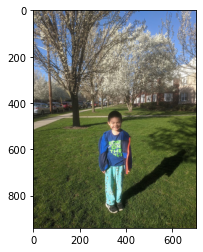

In [2]:
import torch
from torch.autograd import Variable
import torch.nn
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage
import numpy as np
import io
import os
import matplotlib.pyplot as plt
%matplotlib inline


from torchvision.transforms import ToTensor, ToPILImage, transforms
 
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

class DaC_net(nn.Module):
    
    def __init__(self):
        super(DaC_net, self).__init__()
        self.fpn_backbone = torchvision.models.detection.backbone_utils.resnet_fpn_backbone('resnet50', pretrained=True )
        self.fpn_backbone.body.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), bias=False)
        self.foreground = nn.Conv2d(256, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        
 
    def forward(self, x):
        
        P2 = self.fpn_backbone(x)["0"]
        forground = self.foreground(P2)
        out = F.log_softmax(forground)
 
        return forground


# net_dac = DaC_net().to(device)
# net_dac.eval()

file = r'C:\Users\N\Pictures\IMG_20200327_172507.jpg'

image = Image.open(file)
plt.imshow(image)

# image = ToTensor()(image).unsqueeze(0).to(device)
    
# img = np.fromarray(img)


plt.show()



# FPN

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class FPN(nn.Module):
    def __init__(self, block, num_blocks):
        super(FPN, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3, bias=False)  # raw
        self.bn1 = nn.BatchNorm2d(64)

        # Bottom-up layers
        self.layer1 = self._make_layer(block,  64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # Top layer
        self.toplayer = nn.Conv2d(2048, 512, kernel_size=1, stride=1, padding=0)  # Reduce channels

        # Smooth layers
        self.smooth1 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.smooth2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.smooth3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

        # Lateral layers
        self.latlayer1 = nn.Conv2d(1024, 512, kernel_size=1, stride=1, padding=0)
        self.latlayer2 = nn.Conv2d( 512, 512, kernel_size=1, stride=1, padding=0)
        self.latlayer3 = nn.Conv2d( 256, 512, kernel_size=1, stride=1, padding=0)
        
        self.conv_foreground = nn.Conv2d( 512, 2, kernel_size=3, stride=1, padding=1)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def _upsample_add(self, x, y):
        '''Upsample and add two feature maps.

        Args:
          x: (Variable) top feature map to be upsampled.
          y: (Variable) lateral feature map.

        Returns:
          (Variable) added feature map.

        Note in PyTorch, when input size is odd, the upsampled feature map
        with `F.upsample(..., scale_factor=2, mode='nearest')`
        maybe not equal to the lateral feature map size.

        e.g.
        original input size: [N,_,15,15] ->
        conv2d feature map size: [N,_,8,8] ->
        upsampled feature map size: [N,_,16,16]

        So we choose bilinear upsample which supports arbitrary output sizes.
        '''
        _,_,H,W = y.size()
        return F.upsample(x, size=(H,W), mode='bilinear') + y

    def forward(self, x):
        # Bottom-up
        c1 = F.relu(self.bn1(self.conv1(x)))
        c1 = F.max_pool2d(c1, kernel_size=3, stride=2, padding=1)
        c2 = self.layer1(c1)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)
        # Top-down
        p5 = self.toplayer(c5)
        p4 = self._upsample_add(p5, self.latlayer1(c4))
        p3 = self._upsample_add(p4, self.latlayer2(c3))
        p2 = self._upsample_add(p3, self.latlayer3(c2))
        # Smooth
        p4 = self.smooth1(p4)
        p3 = self.smooth2(p3)
        p2 = self.smooth3(p2)
        foreground = self.conv_foreground(p2)
#         foreground = F.log_softmax(foreground)
#         return p2, p3, p4, p5
        return foreground


def FPN18():
    return FPN(Bottleneck, [2,4,23,3])
#     return FPN(Bottleneck, [2,2,2,2])

netFPN = FPN18()


# class FPN_DaC(nn.Module):
#     def __init__(fpn):
#         super(FPN_Dac, self).__init__()
    
#     self.fpn = FPN101()
#     self.p1 = self.fpn[0]


print(netFPN)

FPN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (con

In [4]:
# print(net_DaC)


In [161]:
## https://blog.csdn.net/qq_34914551/article/details/103793104

from pycocotools.coco import COCO
import os
import os.path as osp
import sys
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
import cv2
import numpy as np
from pycocotools.coco import COCO
 
path2data=r"L:\Datasets\coco\val2017"
path2json=r"L:\Datasets\coco\annotations\instances_val2017.json"

from pycocotools.coco import COCO

val_info = path2json
val_image = path2data

coco = COCO(val_info)  # 导入验证集
all_ids = coco.imgs.keys()
print(len(all_ids))
person_id = coco.getCatIds(catNms=['person'])
print(person_id)
person_imgs_id = coco.getImgIds(catIds=person_id)
print(len(person_imgs_id))
###
'''
loading annotations into memory...
Done (t=1.45s)
creating index...
index created!
5000  # 验证集样本总数
[1]  # 人这个类的类别id
2693  # 在验证集中，包含人这个类的图像有2693张
'''
###
 

COCO_CLASSES = ('person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
                'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
                'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog',
                'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
                'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
                'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
                'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
                'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
                'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
                'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',*
                'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop',
                'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven',
                'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
                'scissors', 'teddy bear', 'hair drier', 'toothbrush')

COCO_LABEL_MAP = { 1:  1,  2:  2,  3:  3,  4:  4,  5:  5,  6:  6,  7:  7,  8:  8,
                   9:  9, 10: 10, 11: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16,
                  18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24,
                  27: 25, 28: 26, 31: 27, 32: 28, 33: 29, 34: 30, 35: 31, 36: 32,
                  37: 33, 38: 34, 39: 35, 40: 36, 41: 37, 42: 38, 43: 39, 44: 40,
                  46: 41, 47: 42, 48: 43, 49: 44, 50: 45, 51: 46, 52: 47, 53: 48,
                  54: 49, 55: 50, 56: 51, 57: 52, 58: 53, 59: 54, 60: 55, 61: 56,
                  62: 57, 63: 58, 64: 59, 65: 60, 67: 61, 70: 62, 72: 63, 73: 64,
                  74: 65, 75: 66, 76: 67, 77: 68, 78: 69, 79: 70, 80: 71, 81: 72,
                  82: 73, 84: 74, 85: 75, 86: 76, 87: 77, 88: 78, 89: 79, 90: 80}
class COCOAnnotationTransform(object):
    def __init__(self):
        self.label_map = COCO_LABEL_MAP

    def __call__(self, target, width, height):
        scale = np.array([width, height, width, height])
        res = []
        for obj in target:
            if 'bbox' in obj:
                bbox = obj['bbox']
                label_idx = self.label_map[obj['category_id']] - 1
                final_box = list(np.array([bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]])/scale)
                final_box.append(label_idx)
                res += [final_box]  # [xmin, ymin, xmax, ymax, label_idx]
            else:
                print("No bbox found for object ", obj)

        return res  # [[xmin, ymin, xmax, ymax, label_idx], ... ]


class COCODetection(data.Dataset):
    def __init__(self, image_path, info_file, transform=None,
                 target_transform=None, has_gt=True):
        self.root = image_path
        self.coco = COCO(info_file)
        self.ids = list(self.coco.imgToAnns.keys())  # 标签数目 小于样本数目，说明有的图像没有标签

        if len(self.ids) == 0 or not has_gt:  # 如果没有标签或者不需要GT，则直接使用image
            self.ids = list(self.coco.imgs.keys())
        self.transform = transform
        self.target_transform = target_transform

        self.has_gt = has_gt

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        im, gt, masks, h, w, num_crowds = self.pull_item(index)
        return im, (gt, masks, num_crowds)

    def pull_item(self, index):
        img_id = self.ids[index]
        if self.has_gt:
            ann_ids = self.coco.getAnnIds(imgIds=img_id)
            target = self.coco.loadAnns(ann_ids)
        else:
            target = []
        crowd = [x for x in target if ('iscrowd' in x and x['iscrowd'])]
        target = [x for x in target if not ('iscrowd' in x and x['iscrowd'])]
        num_crowds = len(crowd)

        # This is so we ensure that all crowd annotations are at the end of the array
        target += crowd
        file_name = self.coco.loadImgs(img_id)[0]['file_name']
        path = osp.join(self.root, file_name)
        img = cv2.imread(path)
        height, width, _ = img.shape
        if len(target) > 0: # 这样图像中有不是crowd的目标
            masks = [self.coco.annToMask(obj).reshape(-1) for obj in target]
            masks = np.vstack(masks)
            masks = masks.reshape(-1, height, width)
        if self.target_transform is not None and len(target) > 0:
            target = self.target_transform(target, width, height)
        return torch.from_numpy(img).permute(2, 0, 1), target, masks, height, width, num_crowds


from torch.utils.data import DataLoader
import numpy as np


 

loading annotations into memory...
Done (t=0.90s)
creating index...
index created!
5000
[1]
2693


In [6]:
def one_hot(index, classes):
    size = index.size() + (classes,)
    view = index.size() + (1,)

    mask = torch.Tensor(*size).fill_(0)
    index = index.view(*view)
    ones = 1.

    if isinstance(index, Variable):
        ones = Variable(torch.Tensor(index.size()).fill_(1))
        mask = Variable(mask, volatile=index.volatile)

    return mask.scatter_(1, index, ones)


class FocalLoss(nn.Module):

    def __init__(self, gamma=0, eps=1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps

    def forward(self, input, target):
        y = one_hot(target, input.size(-1))
        logit = F.softmax(input, dim=-1)
        logit = logit.clamp(self.eps, 1. - self.eps)

        loss = -1 * y * torch.log(logit) # cross entropy
        loss = loss * (1 - logit) ** self.gamma # focal loss

        return loss.sum()

# Training 

Epoch 20, batch 97240, mean_losses: 0.42173481166362764
learning rate 8.099999999999999e-06


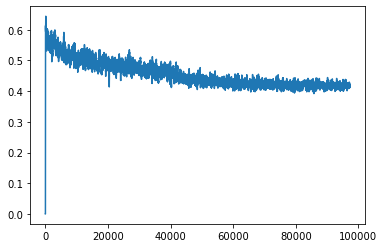

D:\Anaconda3\lib\site-packages\segmentation_models_pytorch\base\modules.py:89: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
D:\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
coco = COCO()

from IPython.display import clear_output
import segmentation_models_pytorch as smp


# net_DaC = DaC_net().to(device)
# net_DaC.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

LR  = 0.001

criterion = nn.NLLLoss2d()

def PIL_to_tensor(image):
    image = ToTensor(image).unsqueeze(0)
    return image.to(device, torch.float)


 
# fl = FocalLoss().cuda()

def CrossEntropy2d(input, target, weight=None, size_average=True):
    
     
    """ 2D version of the cross entropy loss """
    dim = input.dim()
    if dim == 2:
        return F.cross_entropy(input, target, weight, size_average)
 
    elif dim == 4:
        output = input.view(input.size(0),input.size(1), -1)
        output = torch.transpose(output,1,2).contiguous()
        output = output.view(-1,output.size(2))
        target = target.view(-1)
        
#         print("target.shape: ", target.shape)
#         print("output.shape: ", output.shape)
       
        return F.cross_entropy(output, target, weight, size_average)
#         return F.binary_cross_entropy_with_logits(output, target,weight, reduce=False)
#         return fl.forward(output, target)
    else:
        raise ValueError('Expected 2 or 4 dimensions (got {})'.format(dim))
        
        

def masks_merge_np(masks):
    if len(masks) > 0:
        all_masks = np.zeros(masks[0].shape)
        for mask in masks:
            all_masks = np.logical_or(all_masks, mask)
        return all_masks
    return None

def masks_merge_tensor(masks):
    if len(masks) > 0:
        all_masks = torch.zeros(masks[0].shape)
        for mask in masks:
            all_masks = torch.logical_or(all_masks, mask)
        return all_masks
    return None


datasetCOCO = COCODetection(val_image, val_info)
loader = DataLoader(datasetCOCO, shuffle=True)
criterionBCE = nn.BCEWithLogitsLoss()


def train(net, optimizer, epochs, scheduler, save_epoch = 1):
    losses = np.zeros(100000000)
    mean_losses = np.zeros(100000000)
 
  
    iter_count = 1
    
    
    factor = 32 # e.g., if factor = 8, Unet will resize the input as H/8, W/8. the image size should be multiple of 8
    
    for e in range(1, epochs + 1):
         
        print('epoch #:',e)
        ee = e
  
        net.train()

        for img, label in loader: 
            
            img = img / 255.0
            
#             print(img)
            
           
        
            N, C, H, W = img.shape
            
            
            # make the H, W are the multiple of factor (e.g., 8)

            H = (H // factor) * factor
            W = (W // factor) * factor
            
            img = img[:, :, :H, :W]
            
            img = img.to(device)
            
#             img = img.squeeze(0)
            
            
            
#             print("output.shape: ", type(output), output.shape)
            
            gt, masks, num_crowds = label
 
            masks = masks.squeeze(0)
#             print("masks.shape: ", type(masks), masks.shape)
    
 
            all_masks = masks_merge_tensor(masks)
            
            all_masks = all_masks[:H, :W]
#             print("all_masks.shape: ", type(all_masks), all_masks.shape)

#             
#             print("mask_img.shape: ", type(mask_img), mask_img.size)

#             mask_img = ToPILImage(mode=None)(all_masks.int())
#             plt.imshow(mask_img)
#             plt.show() 
        
        
#             print("mask_img.sum(): ", np.array(mask_img).sum())
#             print("mask_img: ", np.array(mask_img))
            
#             mask_img = mask_img.resize((W, H))
            
#             all_masks_tensor = ToTensor()(mask_img)


            
#             all_masks_tensor = all_masks_tensor.bool()
            all_masks = all_masks.long().to(device)
#             print("all_masks.sum(): ", all_masks.sum())
#             print("all_masks.shape: ", all_masks.shape)
            
    
#             print("img.shape: ", type(img), img.shape)
        
            output = net(img)
#             loss = loss_dice(output, all_masks)
#             loss = criterion(output, all_masks)
        
            loss = CrossEntropy2d(output, all_masks)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            
#             N, C, H, W = output.shape
            
            
#             plt.imshow(mask_img)
#             plt.show() 
            
  
#             all_masks_tensor = all_masks_tensor.unsqueeze(0)
#             all_masks = all_masks_tensor.float().to(device)
            
#             print(all_masks)
            
            
            
             
            
#             loss = FocalLoss(output, all_masks)
#             output = F.log_softmax(output, dim=1)


#             loss = calc_loss(outputs, labels, metrics)
    
#             loss = criterionBCE(output, all_masks)
            
            
            if scheduler is not None:
                scheduler.step(loss.item())
            
            iter_count += 1
            
            iter_print_interval = 20
            
            losses[iter_count] = loss.item()
            mean_losses[iter_count] = np.mean(losses[max(0,iter_count-100): iter_count])
            
            if iter_count % iter_print_interval == 0 :
                
                clear_output()
             
                print("Epoch {}, batch {}, mean_losses: {}".format(e, iter_count, mean_losses[iter_count]))
                print("learning rate {}".format(optimizer.param_groups[0]['lr']))
                plt.plot(mean_losses[:iter_count])
                plt.show()
                
                
            

#             all_masks = np.uint8(all_masks.squeeze().numpy().transpose(1, 2, 0))

#             if iter_count % 1000 == 999:
        PATH = r'net_Dac.pth'
        torch.save(net, PATH)

        PATH = r'net_Dac_dict.pth'
        torch.save(net.state_dict(), PATH)

        print("Saved! ")

            
             
    return losses, mean_losses

loss_dice = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# net_DaC = net_DaC.to(device)

# netFPN = netFPN.to(device)

# unet5layer = UNet5layer().to(device)

unet = UNet(3,2).to(device)
# unet2 = UNet2(2).to(device)

# import torch
# model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
#     in_channels=3, out_channels=1, init_features=32, pretrained=True)

# model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=False, progress=True, num_classes=1, aux_loss=None)

model = smp.PSPNet('resnet34', classes=2, activation='softmax')
model = model.to(device)

criterion = nn.CrossEntropyLoss()  #损失函数为交叉熵，多用于多分类问题
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4) #优化方式为mini-batch momentum-SGD，并采用L2正则化（权重衰减）
        
import torch.optim.lr_scheduler
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [3, 5, 7, 9], gamma=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.3, patience=15000)


def masks_merge_tensor(masks):
    if len(masks) > 0:
        all_masks = torch.zeros(masks[0].shape)
        for mask in masks:
            all_masks = torch.logical_or(all_masks, mask)
        return all_masks
    return None

losses, mean_losses = train(model, optimizer, 20,  scheduler=scheduler)

# U-Net

In [110]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, in_channels=3, n_class=2):
        super().__init__()
                
        self.dconv_down1 = double_conv(in_channels, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)      
#         print(x.shape)
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x) 
#         print(x.shape)
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

In [90]:
from torchsummary import summary
summary(unet, input_size=(3, 640, 449))


torch.Size([2, 512, 160, 112])
torch.Size([2, 256, 320, 224])


RuntimeError: Sizes of tensors must match except in dimension 3. Got 449 and 448

In [59]:
import torch
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet2(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

In [7]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
    
import torch.nn.functional as F
 


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits    

In [29]:
import torch
import torch.nn as nn
from torchvision import models

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

from collections import defaultdict
import torch.nn.functional as F
from loss import dice_loss

class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out
    

from collections import defaultdict
import torch.nn.functional as F
from loss import dice_loss

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))


ModuleNotFoundError: No module named 'loss'

In [17]:
PATH = r'net_Dac.pth'
torch.save(net_DaC, PATH)

PATH = r'net_Dac_dict.pth'
torch.save(net_DaC.state_dict(), PATH)


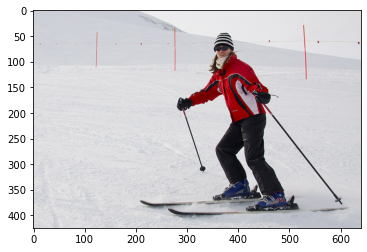

In [34]:
# model = torch.load(PATH)
netFPN.eval()

file = r'C:\Users\N\Pictures\IMG_20200327_172507.jpg'
file = r'L:\Datasets\coco\val2017\000000000785.jpg'

image = Image.open(file)
plt.imshow(image)
plt.show()



image = ToTensor()(image).unsqueeze(0).to(device)
    
# print(image)

out = netFPN(image)

In [35]:
print("shape from model:", out.shape)

shape from model: torch.Size([1, 2, 107, 160])


In [36]:
out_cpu = out.cpu()

out_cpu = out_cpu.squeeze(0)
 
print("shape out_cpu:", out_cpu.shape)
print(out_cpu)

out_np = out_cpu.detach().numpy()
print("shape out_np:", out_np.shape)

# out_np = ToPILImage(mode="LA")(out_cpu.squeeze(0)) 
# print("shape out_np:", out_np.size)
# print(out_np)

pred = np.argmax(out_np, axis=0)
print(pred)

shape out_cpu: torch.Size([2, 107, 160])
tensor([[[ 1.9261,  2.2939,  2.7237,  ...,  6.9099,  7.3081,  5.2031],
         [ 1.9199,  1.8612,  2.1722,  ...,  6.3170,  6.7441,  5.1103],
         [ 2.4037,  2.5375,  3.0054,  ...,  6.8386,  6.8431,  5.2167],
         ...,
         [ 0.9949,  1.0112,  1.4051,  ...,  1.4546,  1.5650,  1.6288],
         [ 1.0108,  1.1071,  1.5152,  ...,  1.6750,  1.7924,  1.7945],
         [ 1.1577,  1.5312,  1.8517,  ...,  1.8180,  1.9184,  1.7551]],

        [[-1.6626, -1.9924, -2.4130,  ..., -6.1537, -6.6724, -4.7607],
         [-1.8610, -1.8584, -2.2189,  ..., -5.9554, -6.6745, -4.7133],
         [-2.2412, -2.4190, -2.9201,  ..., -6.8851, -7.2312, -5.2129],
         ...,
         [-1.1195, -1.0394, -1.5269,  ..., -1.5669, -1.6197, -1.5523],
         [-1.0476, -1.0678, -1.5219,  ..., -1.6974, -1.7690, -1.7438],
         [-1.3079, -1.5875, -1.8647,  ..., -1.7863, -1.8118, -1.6042]]],
       grad_fn=<SqueezeBackward1>)
shape out_np: (2, 107, 160)
[[0 0 0 ... 

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


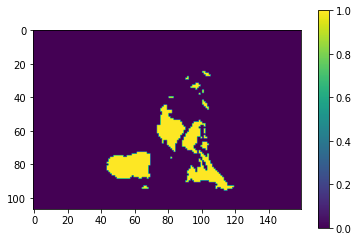

In [37]:
plt.imshow(pred)
plt.colorbar()
print(pred)

In [40]:


pred = np.argmax(out, axis=-1)

out = pred.cpu()

out = ToPILImage(mode="L")(out[0])


print("shape of PIL: ", out.shape)

# out = out.data.cpu().numpy()

print(out.shape)

plt.imshow(out)

# img = np.fromarray(img)


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# print(model)

In [2]:
parm={}
for name,parameters in model.named_parameters():
  print(name,':',parameters.size())
  parm[name]=parameters.detach().numpy()

NameError: name 'model' is not defined

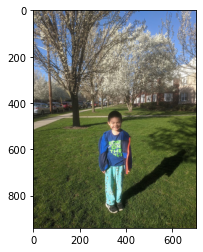

In [3]:

# fm = net_dac(image)
# print(fm.shape)
# del fm

In [5]:
import torchvision.datasets as dset
from torchvision.transforms import ToTensor, ToPILImage
path2data=r"L:\Datasets\coco\train2017"
path2json=r"L:\Datasets\coco\annotations\instances_train2017.json"


     


# 准备数据集并预处理
transform_train = transforms.Compose([
    transforms.ToTensor()
])

BATCH_SIZE = 1
 

# coco_train = dset.CocoDetection(root = path2data, annFile = path2json, transform=transform_train)
coco_train = dset.CocoDetection(root = path2data, annFile = path2json)


print('Number of samples: ', len(coco_train))


train_loader = torch.utils.data.DataLoader(coco_train)

loading annotations into memory...
Done (t=23.79s)
creating index...
index created!
Number of samples:  118287


loading annotations into memory...
Done (t=0.93s)
creating index...
index created!
5000
[1]
2693


In [7]:
import matplotlib.pyplot as plt

path2data=r"L:\Datasets\coco\val2017"
path2json=r"L:\Datasets\coco\annotations\instances_val2017.json"

from pycocotools.coco import COCO

val_info = r"L:\Datasets\coco\annotations\instances_val2017.json"
val_image = r"L:\Datasets\coco\val2017"

def masks_merge(masks):
    if len(masks) > 0:
        all_masks = np.zeros(masks[0].shape)
        for mask in masks:
            all_masks = np.logical_or(all_masks, mask)
        return all_masks
    return None

datasetCOCO = COCODetection(val_image, val_info)
loader = DataLoader(datasetCOCO)
for img, label in loader:
    img = np.uint8(img.squeeze().numpy().transpose(1, 2, 0))
    gt, masks, num_crowds = label
    masks = masks.squeeze(0)
    
#     print(gt)
    print(gt[0]['image_id'])
    
#     plt.imshow(masks[0])
#     plt.show()
    all_masks = masks_merge(masks)
    
    print(all_masks.shape)
    
    plt.imshow(all_masks)
    plt.show() 
    
    for m in range(masks.size(0)):
        mask = masks[m].numpy()
        color = np.random.randint(0, 255)
        channel = np.random.randint(0, 3)
        y, x = np.where(mask == 1)
        img[y, x, channel] = color
        
        
        
        plt.imshow(mask)
        plt.show()
        
           


loading annotations into memory...
Done (t=0.79s)
creating index...
index created!
tensor([289343])
torch.Size([640, 529])
tensor([61471])
torch.Size([480, 640])
tensor([472375])
torch.Size([612, 612])
tensor([520301])
torch.Size([640, 480])
tensor([579321])

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



torch.Size([498, 640])
tensor([494869])
torch.Size([640, 427])
tensor([554002])
torch.Size([425, 640])
tensor([78823])
torch.Size([480, 640])
tensor([419974])
torch.Size([640, 426])
tensor([404484])
torch.Size([240, 320])
tensor([329219])
torch.Size([427, 640])
tensor([68078])
torch.Size([640, 360])
tensor([170893])
torch.Size([480, 640])
tensor([65485])
torch.Size([364, 640])
tensor([498286])
torch.Size([480, 640])
tensor([424162])
torch.Size([512, 640])
tensor([61108])
torch.Size([480, 640])
tensor([67213])
torch.Size([485, 640])
tensor([365207])
torch.Size([588, 640])
tensor([131273])
torch.Size([640, 480])
tensor([279278])
torch.Size([429, 640])
tensor([482100])
torch.Size([427, 640])
tensor([540502])
torch.Size([427, 640])
tensor([127182])
torch.Size([640, 427])
tensor([565776])
torch.Size([421, 640])
tensor([575970])
torch.Size([480, 640])
tensor([462614])
torch.Size([484, 640])
tensor([407614])
torch.Size([426, 640])
tensor([522007])
torch.Size([480, 640])
tensor([226984])
torc

KeyboardInterrupt: 

In [5]:
from IPython.display import clear_output
base_lr = 0.001

optimizer = optim.SGD(net_DaC.parameters(), lr=base_lr, momentum=0.9, weight_decay=0.0005)
# We define the scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [25, 35, 45,55,65,80,90,100], gamma=0.1)


NameError: name 'net_DaC' is not defined

In [6]:

datasetCOCO = COCODetection(val_image, val_info)
loader = DataLoader(datasetCOCO)


loading annotations into memory...
Done (t=1.03s)
creating index...
index created!


In [11]:
coco = COCO()

net_DaC = DaC_net().to(device)
net_DaC.eval()

LR  = 0.001

def PIL_to_tensor(image):
    image = ToTensor(image).unsqueeze(0)
    return image.to(device, torch.float)


criterion = nn.CrossEntropyLoss()  #损失函数为交叉熵，多用于多分类问题
optimizer = optim.SGD(net_DaC.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4) #优化方式为mini-batch momentum-SGD，并采用L2正则化（权重衰减）

def CrossEntropy2d(input, target, weight=None, size_average=True):
    
    """ 2D version of the cross entropy loss """
    dim = input.dim()
    if dim == 2:
        return F.cross_entropy(input, target, weight, size_average)
 
    elif dim == 4:
        output = input.view(input.size(0),input.size(1), -1)
        output = torch.transpose(output,1,2).contiguous()
        output = output.view(-1,output.size(2))
        target = target.view(-1)
        
#         print("target.shape: ", target.shape)
#         print("output.shape: ", output.shape)
       
        return F.cross_entropy(output, target,weight, size_average)
    else:
        raise ValueError('Expected 2 or 4 dimensions (got {})'.format(dim))
        

def masks_merge(masks):
    if len(masks) > 0:
        all_masks = np.zeros(masks[0].shape)
        for mask in masks:
            all_masks = np.logical_or(all_masks, mask)
        return all_masks
    return None

datasetCOCO = COCODetection(val_image, val_info)
loader = DataLoader(datasetCOCO)


def train(net, optimizer, epochs, scheduler=None, save_epoch = 1):
    losses = np.zeros(100000000)
    mean_losses = np.zeros(100000000)
 
  
    iter_count = 0
    
    for e in range(1, epochs + 1):
         
        print('epoch #:',e)
        ee = e
  
        net.train()

        for img, label in loader:
            
            img = img / 255.0
            
#             print("img.shape: ", type(img), img.shape)
            
            img = img.to(device)
            
            optimizer.zero_grad()
            output = net(img)
            
            N, C, H, W = output.shape
            
#             print("output.shape: ", type(output), output.shape)
            
            gt, masks, num_crowds = label
 
            masks = masks.squeeze(0)
#             print("masks.shape: ", type(masks), masks.shape)
    
 
            all_masks = masks_merge(masks)
#             print("all_masks.shape: ", type(all_masks), all_masks.shape)

            mask_img = ToPILImage(mode="L")(all_masks)
#             print("mask_img.shape: ", type(mask_img), mask_img.size)
            
            mask_img = mask_img.resize((W, H))
            all_masks = ToTensor()(mask_img).to(device)
            all_masks = all_masks.long()
            
#             plt.imshow(mask_img)
#             plt.show()
 
            
            loss = CrossEntropy2d(output, all_masks)
            loss.backward()
            optimizer.step()
            
            iter_count += 1
            
            iter_print_interval = 20
            
            losses[iter_count] = loss.item()
            mean_losses[iter_count] = np.mean(losses[max(0,iter_count-100): iter_count])
            
            if iter_count % iter_print_interval == (iter_print_interval - 1):
             
                print(mean_losses[iter_count])
            
#             plt.imshow(all_masks)
#             plt.show() 
            
#             all_masks = np.uint8(all_masks.squeeze().numpy().transpose(1, 2, 0))

            
             
    return losses, mean_losses

net_DaC = net_DaC.to(device)

losses, mean_losses = train(net_DaC, optimizer, 50)

loading annotations into memory...
Done (t=1.11s)
creating index...
index created!
epoch #: 1


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
D:\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


0.08212693140790418
0.04001143672660754
0.026448634314933422
0.019752979376168562
0.01576262685249779
1.06466530823468e-06
8.356807590104154e-07
7.470018693567226e-07
7.247891458206368e-07
6.99057215243215e-07
6.777780672706512e-07
7.288302919050693e-07
7.130267701427329e-07
7.7473215732482e-07
8.426210190037863e-07
7.973907577962791e-07
8.051501944095207e-07
8.221663366470011e-07
8.073183964540931e-07
7.54692350994901e-07
7.951939848283019e-07
7.248990409891576e-07
7.245447373804837e-07
6.712211413173464e-07
7.436926627235607e-07


KeyboardInterrupt: 

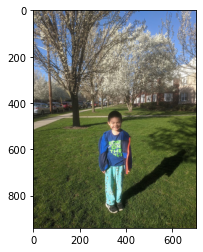

RuntimeError: CUDA out of memory. Tried to allocate 160.00 MiB (GPU 0; 11.00 GiB total capacity; 8.50 GiB already allocated; 14.32 MiB free; 8.73 GiB reserved in total by PyTorch)

torch.Size([1, 2, 468, 350])
(1, 468, 350)


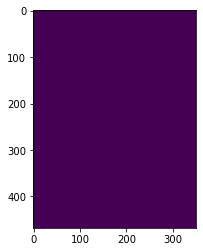

In [24]:
print(out.shape)

out2 = out.data.cpu().numpy()

pred = np.argmax(out2, axis=1)

print(pred.shape)

plt.imshow(pred[0])

In [18]:
coco = COCO()
def PIL_to_tensor(image):
    image = ToTensor(image).unsqueeze(0)
    return image.to(device, torch.float)

def train(net, optimizer, epochs, scheduler=None, save_epoch = 1):
    losses = np.zeros(100000000)
    mean_losses = np.zeros(100000000)
 
  
    iter_ = 0
    
    for e in range(1, epochs + 1):
         
        print('epoch #:',e)
        ee = e
  
        net.train()

        for batch_idx, (data, target) in enumerate(train_loader):
 
            try:                     
                
                data  = data.cuda()

        
                print('data.shape: ', data.shape)
                print("target: ", target)
                
#                 anns = coco.loadAnns(target)
                
                m = coco.annToMask(target[0])
                
                print('m: ', m)
                                      
                optimizer.zero_grad()
                output = net(data)
#                 print('shape of output:', output.shape, type(output))

                loss = CrossEntropy2d(output, target)
                loss.backward()
                optimizer.step()
                
                if scheduler is not None:
                    scheduler.step()
      
            except Exception as e:
                print(e)
                continue

            losses[iter_] = loss.item()
            mean_losses[iter_] = np.mean(losses[max(0,iter_-100):iter_])

#             if iter_ % 1500 == 0:
#                 clear_output()
#                 rgb = np.asarray(255 * np.transpose(data.data.cpu().numpy()[0],(1,2,0)), dtype='uint8')
#                 pred = np.argmax(output.data.cpu().numpy()[0], axis=0)
#                 gt = target.data.cpu().numpy()[0]
#                 print('e:',ee)
#                 print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}'.format(
#                     ee, epochs, batch_idx, len(train_loader),
                     
#                     100. * batch_idx / len(train_loader), loss.item(), accuracy(pred, gt)))
#                 plt.plot(mean_losses[:iter_]) and plt.show()
#                 fig = plt.figure(figsize=(256, 256))
#                 fig.add_subplot(131)
#                 plt.imshow(rgb)
#                 plt.title('RGB')
#                 fig.add_subplot(132)
#                 plt.imshow(convert_to_color(gt))
#                 plt.title('Ground truth')
#                 fig.add_subplot(133)
#                 plt.title('Prediction')
#                 plt.imshow(convert_to_color(pred))
#                 plt.show()

#                 print('Current percentage of epoch: {:.2f}'.format(current_train_idx / len(train_ids)))
#                 print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}'.format(
#                     ee, epochs, batch_idx, len(train_loader),
                    
#                     100. * batch_idx / len(train_loader), loss.item(), accuracy(pred, gt)))

#                 print("learning rate {}".format(optimizer.param_groups[0]['lr']))

            iter_ += 1



        if ee % save_epoch == 0:
            torch.save(net.state_dict(), 'Epoch{%2d}.pth'.format(e))
 
       
    print("Training finished!")
    
 
    for i in range(len(losses[:iter_])):
        f.writelines("{} {} {} {}".format(i, losses[i], mean_losses[i], '\n'))
    f.close()
    
    return losses, mean_losses

losses, mean_losses = train(net_DaC, optimizer, 50, scheduler=None)

epoch #: 1


NameError: name 'train_loader' is not defined

In [61]:
net_DaC.fpn_backbone.body.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), bias=False)
# print(net_DaC)

fm = net_DaC(image)
print(fm["0"].shape)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [45]:
print(fm["0"].shape)
print(fm["1"].shape)
print(fm["2"].shape)
print(fm["3"].shape)


torch.Size([1, 256, 468, 350])
torch.Size([1, 256, 234, 175])
torch.Size([1, 256, 117, 88])
torch.Size([1, 256, 59, 44])


In [22]:
net = net_DaC.to(device)

print(net)

# 定义损失函数和优化方式
criterion = nn.CrossEntropyLoss()  #损失函数为交叉熵，多用于多分类问题
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4) #优化方式为mini-batch momentum-SGD，并采用L2正则化（权重衰减）

# 训练
if __name__ == "__main__":
#     if not os.path.exists(args.outf):
#         os.makedirs(args.outf)
    best_acc = 85  #2 初始化best test accuracy
    print("Start Training, Resnet-18!")  # 定义遍历数据集的次数
    with open("acc.txt", "w") as f:
        with open("log.txt", "w")as f2:
            for epoch in range(pre_epoch, EPOCH):
                print('\nEpoch: %d' % (epoch + 1))
                net.train()
                sum_loss = 0.0
                correct = 0.0
                total = 0.0
                for i, data in enumerate(trainloader, 0):
                    # 准备数据
                    length = len(trainloader)
                    inputs, labels = data
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()

                    # forward + backward
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    
                    for param_group in optimizer.param_groups:
                        print("param_group[‘lr’]:", param_group['lr'])
                    
#                     print(optimizer.)

                    # 每训练1个batch打印一次loss和准确率
                    sum_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += predicted.eq(labels.data).cpu().sum()
                    print('[epoch:%d, iter:%d] Loss: %.03f | Acc: %.3f%% '
                          % (epoch + 1, (i + 1 + epoch * length), sum_loss / (i + 1), 100. * correct / total))
                    f2.write('%03d  %05d |Loss: %.03f | Acc: %.3f%% '
                          % (epoch + 1, (i + 1 + epoch * length), sum_loss / (i + 1), 100. * correct / total))
                    f2.write('\n')
                    f2.flush()

                # 每训练完一个epoch测试一下准确率
                print("Waiting Test!")
                with torch.no_grad():
                    correct = 0
                    total = 0
                    for data in testloader:
                        net.eval()
                        images, labels = data
                        images, labels = images.to(device), labels.to(device)
                        outputs = net(images)
                        # 取得分最高的那个类 (outputs.data的索引号)
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum()
                    print('测试分类准确率为：%.3f%%' % (100 * correct / total))
                    acc = 100. * correct / total
                    # 将每次测试结果实时写入acc.txt文件中
                    print('Saving model......')
                    torch.save(net.state_dict(), 'resnet_%03d.pth' % (epoch + 1))
                    f.write("EPOCH=%03d,Accuracy= %.3f%%" % (epoch + 1, acc))
                    f.write('\n')
                    f.flush()
                    # 记录最佳测试分类准确率并写入best_acc.txt文件中
                    if acc > best_acc:
                        f3 = open("best_acc.txt", "w")
                        f3.write("EPOCH=%d,best_acc= %.3f%%" % (epoch + 1, acc))
                        f3.close()
                        best_acc = acc
            print("Training Finished, TotalEPOCH=%d" % EPOCH)

234.75

In [91]:
print(len(re))

5


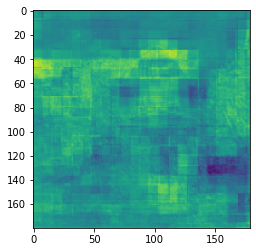

In [112]:
# re["0"].shape
plt.imshow(re["0"].detach().numpy()[0][9] )

In [75]:
re["1"].shape

torch.Size([1, 256, 90, 90])

In [76]:
re["2"].shape

torch.Size([1, 256, 45, 45])

In [77]:
re["3"].shape

torch.Size([1, 256, 23, 23])

In [79]:
re["pool"].shape

torch.Size([1, 256, 12, 12])

In [25]:
import torch
from torch.autograd import Variable
import torch.nn

class my_net(nn.Module):
    def __init__(self):
        super(my_net, self).__init__()
        self.features1 = torch.nn.Sequential(
                            torch.nn.Conv2d(3, 5, 3, padding=1),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(5, 10, 3, padding=1),
                            )
        # Take the output of this layer as the input of net2
        self.features2 = torch.nn.Sequential(
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(10, 15, 3, padding=1)
                            )
    def forward(self, x):
        x1 = self.features1(x)
        x2 = self.features2(x1)

        # 呃呃呃呃呃， 对，通过这种方式进行返回，虽然ugly，但是straightforward
        return (x1,x2)

class my_net2(nn.Module):
    def __init__(self):
        super(my_net2, self).__init__()
        self.features = torch.nn.Sequential(
                            torch.nn.Conv2d(10, 25, 3, padding=1)
                            )
    def forward(self, x):
        x = self.features(x)
        return x

net1 = my_net().cuda()
net2 = my_net2().cuda()


input1 = Variable(torch.ones(1, 3, 10, 10).cuda())
feat_for_net2, out1 = net1(input1)

# input of net2 are features got from net1
input2 = feat_for_net2
out2 = net2(input2)

# Create targets
target1 = Variable(torch.ones_like(out1.data)).cuda()
target2 = Variable(torch.ones(1, 25, 10, 10)*2).cuda()


criterion1 = torch.nn.MSELoss(size_average=False)
criterion2 = torch.nn.MSELoss(size_average=False)

loss1 = criterion1(out1, target1)

loss2 = criterion2(out2, target2)

loss = loss1+loss2
loss.backward()
 

In [27]:
from collections import OrderedDict

import torch
from torch import nn
import torch.nn.functional as F

from torchvision.ops import misc as misc_nn_ops
from torchvision.ops import MultiScaleRoIAlign

from ..utils import load_state_dict_from_url

from .generalized_rcnn import GeneralizedRCNN
from .rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
from .roi_heads import RoIHeads
from .transform import GeneralizedRCNNTransform
from .backbone_utils import resnet_fpn_backbone


__all__ = [
    "FasterRCNN", "fasterrcnn_resnet50_fpn",
]


class FasterRCNN(GeneralizedRCNN):
    """
    Implements Faster R-CNN.
    The input to the model is expected to be a list of tensors, each of shape [C, H, W], one for each
    image, and should be in 0-1 range. Different images can have different sizes.
    The behavior of the model changes depending if it is in training or evaluation mode.
    During training, the model expects both the input tensors, as well as a targets (list of dictionary),
    containing:
        - boxes (FloatTensor[N, 4]): the ground-truth boxes in [x1, y1, x2, y2] format, with values of x
          between 0 and W and values of y between 0 and H
        - labels (Int64Tensor[N]): the class label for each ground-truth box
    The model returns a Dict[Tensor] during training, containing the classification and regression
    losses for both the RPN and the R-CNN.
    During inference, the model requires only the input tensors, and returns the post-processed
    predictions as a List[Dict[Tensor]], one for each input image. The fields of the Dict are as
    follows:
        - boxes (FloatTensor[N, 4]): the predicted boxes in [x1, y1, x2, y2] format, with values of x
          between 0 and W and values of y between 0 and H
        - labels (Int64Tensor[N]): the predicted labels for each image
        - scores (Tensor[N]): the scores or each prediction
    Arguments:
        backbone (nn.Module): the network used to compute the features for the model.
            It should contain a out_channels attribute, which indicates the number of output
            channels that each feature map has (and it should be the same for all feature maps).
            The backbone should return a single Tensor or and OrderedDict[Tensor].
        num_classes (int): number of output classes of the model (including the background).
            If box_predictor is specified, num_classes should be None.
        min_size (int): minimum size of the image to be rescaled before feeding it to the backbone
        max_size (int): maximum size of the image to be rescaled before feeding it to the backbone
        image_mean (Tuple[float, float, float]): mean values used for input normalization.
            They are generally the mean values of the dataset on which the backbone has been trained
            on
        image_std (Tuple[float, float, float]): std values used for input normalization.
            They are generally the std values of the dataset on which the backbone has been trained on
        rpn_anchor_generator (AnchorGenerator): module that generates the anchors for a set of feature
            maps.
        rpn_head (nn.Module): module that computes the objectness and regression deltas from the RPN
        rpn_pre_nms_top_n_train (int): number of proposals to keep before applying NMS during training
        rpn_pre_nms_top_n_test (int): number of proposals to keep before applying NMS during testing
        rpn_post_nms_top_n_train (int): number of proposals to keep after applying NMS during training
        rpn_post_nms_top_n_test (int): number of proposals to keep after applying NMS during testing
        rpn_nms_thresh (float): NMS threshold used for postprocessing the RPN proposals
        rpn_fg_iou_thresh (float): minimum IoU between the anchor and the GT box so that they can be
            considered as positive during training of the RPN.
        rpn_bg_iou_thresh (float): maximum IoU between the anchor and the GT box so that they can be
            considered as negative during training of the RPN.
        rpn_batch_size_per_image (int): number of anchors that are sampled during training of the RPN
            for computing the loss
        rpn_positive_fraction (float): proportion of positive anchors in a mini-batch during training
            of the RPN
        box_roi_pool (MultiScaleRoIAlign): the module which crops and resizes the feature maps in
            the locations indicated by the bounding boxes
        box_head (nn.Module): module that takes the cropped feature maps as input
        box_predictor (nn.Module): module that takes the output of box_head and returns the
            classification logits and box regression deltas.
        box_score_thresh (float): during inference, only return proposals with a classification score
            greater than box_score_thresh
        box_nms_thresh (float): NMS threshold for the prediction head. Used during inference
        box_detections_per_img (int): maximum number of detections per image, for all classes.
        box_fg_iou_thresh (float): minimum IoU between the proposals and the GT box so that they can be
            considered as positive during training of the classification head
        box_bg_iou_thresh (float): maximum IoU between the proposals and the GT box so that they can be
            considered as negative during training of the classification head
        box_batch_size_per_image (int): number of proposals that are sampled during training of the
            classification head
        box_positive_fraction (float): proportion of positive proposals in a mini-batch during training
            of the classification head
        bbox_reg_weights (Tuple[float, float, float, float]): weights for the encoding/decoding of the
            bounding boxes
    Example::
        >>> import torch
        >>> import torchvision
        >>> from torchvision.models.detection import FasterRCNN
        >>> from torchvision.models.detection.rpn import AnchorGenerator
        >>> # load a pre-trained model for classification and return
        >>> # only the features
        >>> backbone = torchvision.models.mobilenet_v2(pretrained=True).features
        >>> # FasterRCNN needs to know the number of
        >>> # output channels in a backbone. For mobilenet_v2, it's 1280
        >>> # so we need to add it here
        >>> backbone.out_channels = 1280
        >>>
        >>> # let's make the RPN generate 5 x 3 anchors per spatial
        >>> # location, with 5 different sizes and 3 different aspect
        >>> # ratios. We have a Tuple[Tuple[int]] because each feature
        >>> # map could potentially have different sizes and
        >>> # aspect ratios
        >>> anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
        >>>                                    aspect_ratios=((0.5, 1.0, 2.0),))
        >>>
        >>> # let's define what are the feature maps that we will
        >>> # use to perform the region of interest cropping, as well as
        >>> # the size of the crop after rescaling.
        >>> # if your backbone returns a Tensor, featmap_names is expected to
        >>> # be ['0']. More generally, the backbone should return an
        >>> # OrderedDict[Tensor], and in featmap_names you can choose which
        >>> # feature maps to use.
        >>> roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
        >>>                                                 output_size=7,
        >>>                                                 sampling_ratio=2)
        >>>
        >>> # put the pieces together inside a FasterRCNN model
        >>> model = FasterRCNN(backbone,
        >>>                    num_classes=2,
        >>>                    rpn_anchor_generator=anchor_generator,
        >>>                    box_roi_pool=roi_pooler)
        >>> model.eval()
        >>> x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
        >>> predictions = model(x)
    """

    def __init__(self, backbone, num_classes=None,
                 # transform parameters
                 min_size=800, max_size=1333,
                 image_mean=None, image_std=None,
                 # RPN parameters
                 rpn_anchor_generator=None, rpn_head=None,
                 rpn_pre_nms_top_n_train=2000, rpn_pre_nms_top_n_test=1000,
                 rpn_post_nms_top_n_train=2000, rpn_post_nms_top_n_test=1000,
                 rpn_nms_thresh=0.7,
                 rpn_fg_iou_thresh=0.7, rpn_bg_iou_thresh=0.3,
                 rpn_batch_size_per_image=256, rpn_positive_fraction=0.5,
                 # Box parameters
                 box_roi_pool=None, box_head=None, box_predictor=None,
                 box_score_thresh=0.05, box_nms_thresh=0.5, box_detections_per_img=100,
                 box_fg_iou_thresh=0.5, box_bg_iou_thresh=0.5,
                 box_batch_size_per_image=512, box_positive_fraction=0.25,
                 bbox_reg_weights=None):

        if not hasattr(backbone, "out_channels"):
            raise ValueError(
                "backbone should contain an attribute out_channels "
                "specifying the number of output channels (assumed to be the "
                "same for all the levels)")

        assert isinstance(rpn_anchor_generator, (AnchorGenerator, type(None)))
        assert isinstance(box_roi_pool, (MultiScaleRoIAlign, type(None)))

        if num_classes is not None:
            if box_predictor is not None:
                raise ValueError("num_classes should be None when box_predictor is specified")
        else:
            if box_predictor is None:
                raise ValueError("num_classes should not be None when box_predictor "
                                 "is not specified")

        out_channels = backbone.out_channels

        if rpn_anchor_generator is None:
            anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
            aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
            rpn_anchor_generator = AnchorGenerator(
                anchor_sizes, aspect_ratios
            )
        if rpn_head is None:
            rpn_head = RPNHead(
                out_channels, rpn_anchor_generator.num_anchors_per_location()[0]
            )

        rpn_pre_nms_top_n = dict(training=rpn_pre_nms_top_n_train, testing=rpn_pre_nms_top_n_test)
        rpn_post_nms_top_n = dict(training=rpn_post_nms_top_n_train, testing=rpn_post_nms_top_n_test)

        rpn = RegionProposalNetwork(
            rpn_anchor_generator, rpn_head,
            rpn_fg_iou_thresh, rpn_bg_iou_thresh,
            rpn_batch_size_per_image, rpn_positive_fraction,
            rpn_pre_nms_top_n, rpn_post_nms_top_n, rpn_nms_thresh)

        if box_roi_pool is None:
            box_roi_pool = MultiScaleRoIAlign(
                featmap_names=['0', '1', '2', '3'],
                output_size=7,
                sampling_ratio=2)

        if box_head is None:
            resolution = box_roi_pool.output_size[0]
            representation_size = 1024
            box_head = TwoMLPHead(
                out_channels * resolution ** 2,
                representation_size)

        if box_predictor is None:
            representation_size = 1024
            box_predictor = FastRCNNPredictor(
                representation_size,
                num_classes)

        roi_heads = RoIHeads(
            # Box
            box_roi_pool, box_head, box_predictor,
            box_fg_iou_thresh, box_bg_iou_thresh,
            box_batch_size_per_image, box_positive_fraction,
            bbox_reg_weights,
            box_score_thresh, box_nms_thresh, box_detections_per_img)

        if image_mean is None:
            image_mean = [0.485, 0.456, 0.406]
        if image_std is None:
            image_std = [0.229, 0.224, 0.225]
        transform = GeneralizedRCNNTransform(min_size, max_size, image_mean, image_std)

        super(FasterRCNN, self).__init__(backbone, rpn, roi_heads, transform)


class TwoMLPHead(nn.Module):
    """
    Standard heads for FPN-based models
    Arguments:
        in_channels (int): number of input channels
        representation_size (int): size of the intermediate representation
    """

    def __init__(self, in_channels, representation_size):
        super(TwoMLPHead, self).__init__()

        self.fc6 = nn.Linear(in_channels, representation_size)
        self.fc7 = nn.Linear(representation_size, representation_size)

    def forward(self, x):
        x = x.flatten(start_dim=1)

        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))

        return x


class FastRCNNPredictor(nn.Module):
    """
    Standard classification + bounding box regression layers
    for Fast R-CNN.
    Arguments:
        in_channels (int): number of input channels
        num_classes (int): number of output classes (including background)
    """

    def __init__(self, in_channels, num_classes):
        super(FastRCNNPredictor, self).__init__()
        self.cls_score = nn.Linear(in_channels, num_classes)
        self.bbox_pred = nn.Linear(in_channels, num_classes * 4)

    def forward(self, x):
        if x.dim() == 4:
            assert list(x.shape[2:]) == [1, 1]
        x = x.flatten(start_dim=1)
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)

        return scores, bbox_deltas


model_urls = {
    'fasterrcnn_resnet50_fpn_coco':
        'https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth',
}


def fasterrcnn_resnet50_fpn(pretrained=False, progress=True,
                            num_classes=91, pretrained_backbone=True, trainable_backbone_layers=3, **kwargs):
    """
    Constructs a Faster R-CNN model with a ResNet-50-FPN backbone.
    The input to the model is expected to be a list of tensors, each of shape ``[C, H, W]``, one for each
    image, and should be in ``0-1`` range. Different images can have different sizes.
    The behavior of the model changes depending if it is in training or evaluation mode.
    During training, the model expects both the input tensors, as well as a targets (list of dictionary),
    containing:
        - boxes (``FloatTensor[N, 4]``): the ground-truth boxes in ``[x1, y1, x2, y2]`` format, with values of ``x``
          between ``0`` and ``W`` and values of ``y`` between ``0`` and ``H``
        - labels (``Int64Tensor[N]``): the class label for each ground-truth box
    The model returns a ``Dict[Tensor]`` during training, containing the classification and regression
    losses for both the RPN and the R-CNN.
    During inference, the model requires only the input tensors, and returns the post-processed
    predictions as a ``List[Dict[Tensor]]``, one for each input image. The fields of the ``Dict`` are as
    follows:
        - boxes (``FloatTensor[N, 4]``): the predicted boxes in ``[x1, y1, x2, y2]`` format, with values of ``x``
          between ``0`` and ``W`` and values of ``y`` between ``0`` and ``H``
        - labels (``Int64Tensor[N]``): the predicted labels for each image
        - scores (``Tensor[N]``): the scores or each prediction
    Faster R-CNN is exportable to ONNX for a fixed batch size with inputs images of fixed size.
    Example::
        >>> model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        >>> # For training
        >>> images, boxes = torch.rand(4, 3, 600, 1200), torch.rand(4, 11, 4)
        >>> labels = torch.randint(1, 91, (4, 11))
        >>> images = list(image for image in images)
        >>> targets = []
        >>> for i in range(len(images)):
        >>>     d = {}
        >>>     d['boxes'] = boxes[i]
        >>>     d['labels'] = labels[i]
        >>>     targets.append(d)
        >>> output = model(images, targets)
        >>> # For inference
        >>> model.eval()
        >>> x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
        >>> predictions = model(x)
        >>>
        >>> # optionally, if you want to export the model to ONNX:
        >>> torch.onnx.export(model, x, "faster_rcnn.onnx", opset_version = 11)
    Arguments:
        pretrained (bool): If True, returns a model pre-trained on COCO train2017
        progress (bool): If True, displays a progress bar of the download to stderr
        pretrained_backbone (bool): If True, returns a model with backbone pre-trained on Imagenet
        num_classes (int): number of output classes of the model (including the background)
        trainable_backbone_layers (int): number of trainable (not frozen) resnet layers starting from final block.
            Valid values are between 0 and 5, with 5 meaning all backbone layers are trainable.
    """
    assert trainable_backbone_layers <= 5 and trainable_backbone_layers >= 0
    # dont freeze any layers if pretrained model or backbone is not used
    if not (pretrained or pretrained_backbone):
        trainable_backbone_layers = 5
    if pretrained:
        # no need to download the backbone if pretrained is set
        pretrained_backbone = False
    backbone = resnet_fpn_backbone('resnet50', pretrained_backbone, trainable_layers=trainable_backbone_layers)
    model = FasterRCNN(backbone, num_classes, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['fasterrcnn_resnet50_fpn_coco'],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

ValueError: attempted relative import beyond top-level package

# Tools

##  COCO to foreground

In [159]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def masks_merge_np(masks):
    if len(masks) > 0:
        all_masks = np.zeros(masks[0].shape)
        for mask in masks:
            all_masks = np.logical_or(all_masks, mask)
        return all_masks
    return None

val_image=r"L:\Datasets\coco\train2017"
val_info=r"L:\Datasets\coco\annotations\instances_train2017.json"

datasetCOCO = COCODetection(val_image, val_info)
loader = DataLoader(datasetCOCO, shuffle=True)


iter_loader = iter(loader)

print(len(iter_loader))

loading annotations into memory...
Done (t=26.67s)
creating index...
index created!
117266


0


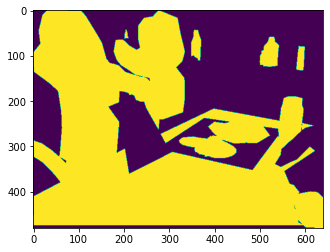

1000


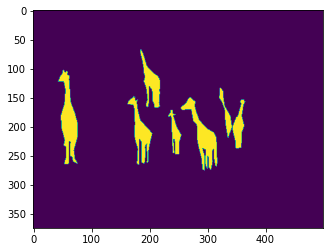

2000


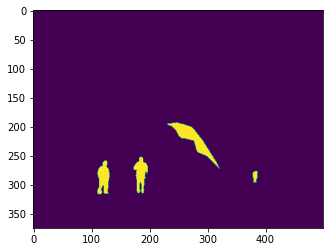

3000


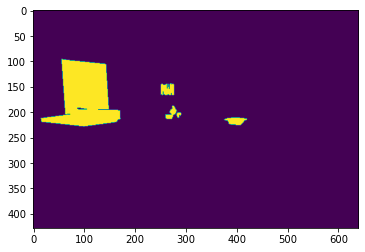

4000


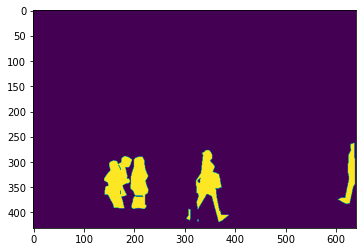

In [155]:
import os

saved_path = r'L:\Datasets\coco\train2017_foreground'


for idx, (im, gt) in enumerate(iter_loader):
    txt, masks = gt[0], gt[1]
    
    masks = masks.squeeze(0).numpy()
    masks = masks_merge_np(masks)
    
    name_length = 12
    
    image_id = txt[0]['image_id'].numpy()
    image_id = str(image_id[0])
    image_id = '0' * (name_length - len(image_id)) + image_id + ".png"
#     print(image_id)
    
    im = Image.fromarray(masks)
    im.save(os.path.join(saved_path, image_id))
    
    if idx % 1000 == 0:
#         for g in txt:
#             print(g['image_id'])
        print(idx)
        plt.imshow(masks)
        plt.show()

    

In [2]:
import glob
files = glob.glob(r'K:\Dataset\Cityscapes\leftImg8bit_trainvaltest\gtFine_trainvaltest\gtFine\train\*\*_gtFine_labelTrainIds.png')
files

['K:\\Dataset\\Cityscapes\\leftImg8bit_trainvaltest\\gtFine_trainvaltest\\gtFine\\train\\aachen\\aachen_000000_000019_gtFine_labelTrainIds.png',
 'K:\\Dataset\\Cityscapes\\leftImg8bit_trainvaltest\\gtFine_trainvaltest\\gtFine\\train\\aachen\\aachen_000001_000019_gtFine_labelTrainIds.png',
 'K:\\Dataset\\Cityscapes\\leftImg8bit_trainvaltest\\gtFine_trainvaltest\\gtFine\\train\\aachen\\aachen_000002_000019_gtFine_labelTrainIds.png',
 'K:\\Dataset\\Cityscapes\\leftImg8bit_trainvaltest\\gtFine_trainvaltest\\gtFine\\train\\aachen\\aachen_000003_000019_gtFine_labelTrainIds.png',
 'K:\\Dataset\\Cityscapes\\leftImg8bit_trainvaltest\\gtFine_trainvaltest\\gtFine\\train\\aachen\\aachen_000004_000019_gtFine_labelTrainIds.png',
 'K:\\Dataset\\Cityscapes\\leftImg8bit_trainvaltest\\gtFine_trainvaltest\\gtFine\\train\\aachen\\aachen_000005_000019_gtFine_labelTrainIds.png',
 'K:\\Dataset\\Cityscapes\\leftImg8bit_trainvaltest\\gtFine_trainvaltest\\gtFine\\train\\aachen\\aachen_000006_000019_gtFine_label